# Obtención de los datos

Usaremos el dataset de trashnet que es un conjunto de datos que tiene alrededor de 2500 imágenes de seis tipos diferentes de basura: vidrio, papel, cartón, plástico, metal y basura.

```consola
git clone https://github.com/garythung/trashnet
```

## Dependencias

In [1]:
import zipfile
import os
import numpy as np

## Proceso

In [2]:
# Descomprimir el zip con la data

data_path: str = './trashnet/data'
zip_path: str = './trashnet/data/dataset-resized.zip'
zip_ref: zipfile.ZipFile = zipfile.ZipFile(zip_path, 'r')
zip_ref.extractall(data_path)
zip_ref.close()

In [9]:
# Separamos entre entrenamiento y validación
validation_path: str = './data/valid'
train_path: str = './data/train'

if not os.path.exists(validation_path):
    os.makedirs(validation_path)
if not os.path.exists(train_path):
    os.makedirs(train_path)

unzipped_data_path = './trashnet/data/dataset-resized'

for file in os.listdir(unzipped_data_path):
    # Se crean los nuevos directorios para data de entrenamiento y validación
    if file != '.DS_Store':
        if not os.path.exists(os.path.join(train_path, file)):
            os.makedirs(os.path.join(train_path, file))
        if not os.path.exists(os.path.join(validation_path, file)):
            os.makedirs(os.path.join(validation_path, file))

for file in os.listdir(unzipped_data_path):
    if file != '.DS_Store':
        # Extrae el 20% de las imágenes para validación (siguiendo la "regla" de 80/20)
        for subfile in os.listdir(os.path.join(unzipped_data_path, file)):
            if subfile != '.DS_Store':
                if np.random.rand(1) < 0.2:
                    os.rename(os.path.join(unzipped_data_path, file, subfile), os.path.join(validation_path, file, subfile))
                else:
                    os.rename(os.path.join(unzipped_data_path, file, subfile), os.path.join(train_path, file, subfile))

FileExistsError: [WinError 183] No se puede crear un archivo que ya existe: './trashnet/data/dataset-resized\\cardboard\\cardboard332.jpg' -> './data/train\\cardboard\\cardboard332.jpg'

Verificamos que cada clase tenga la misma cantidad de imágenes

In [10]:
root_directory = "./data/"

image_extension = ".jpg"  # Change the extension if necessary

train_subdirectories = [os.path.join(root_directory, "train", subdirectory) for subdirectory in os.listdir(os.path.join(root_directory, "train"))]
valid_subdirectories = [os.path.join(root_directory, "valid", subdirectory) for subdirectory in os.listdir(os.path.join(root_directory, "valid"))]

train_min_image_count = min([len([file for file in os.listdir(subdirectory) if file.endswith(image_extension)]) for subdirectory in train_subdirectories])
valid_min_image_count = min([len([file for file in os.listdir(subdirectory) if file.endswith(image_extension)]) for subdirectory in valid_subdirectories])

for subdirectory in train_subdirectories:
    image_files = [file for file in os.listdir(subdirectory) if file.endswith(image_extension)]
    image_count = len(image_files)
    difference = image_count - train_min_image_count

    for i in range(difference):
        image_to_remove = image_files[i]
        image_to_remove_path = os.path.join(subdirectory, image_to_remove)
        os.remove(image_to_remove_path)

    remaining_image_count = len([file for file in os.listdir(subdirectory) if file.endswith(image_extension)])
    print(f"Remaining image count in {subdirectory}: {remaining_image_count}")

for subdirectory in valid_subdirectories:
    image_files = [file for file in os.listdir(subdirectory) if file.endswith(image_extension)]
    image_count = len(image_files)
    difference = image_count - valid_min_image_count

    for i in range(difference):
        image_to_remove = image_files[i]
        image_to_remove_path = os.path.join(subdirectory, image_to_remove)
        os.remove(image_to_remove_path)

    remaining_image_count = len([file for file in os.listdir(subdirectory) if file.endswith(image_extension)])
    print(f"Remaining image count in {subdirectory}: {remaining_image_count}")



Remaining image count in ./data/train\cardboard: 107
Remaining image count in ./data/train\glass: 107
Remaining image count in ./data/train\metal: 107
Remaining image count in ./data/train\paper: 107
Remaining image count in ./data/train\plastic: 107
Remaining image count in ./data/train\trash: 107
Remaining image count in ./data/valid\cardboard: 30
Remaining image count in ./data/valid\glass: 30
Remaining image count in ./data/valid\metal: 30
Remaining image count in ./data/valid\paper: 30
Remaining image count in ./data/valid\plastic: 30
Remaining image count in ./data/valid\trash: 30


# Desarrollo

### Dependencias

In [11]:
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from keras.models import load_model
from keras import regularizers

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## Preprocesamiento de los datos

In [12]:
# Se definen los sets de entrenamiento y validación
train_data_generator: ImageDataGenerator = ImageDataGenerator(
    rescale=1.0/255.0,
    width_shift_range=0.3,
    height_shift_range=0.3,
    rotation_range=30,
    horizontal_flip=True,
    fill_mode='nearest',
    shear_range=0.3,
    zoom_range=0.4
)
    
val_data_generator: ImageDataGenerator = ImageDataGenerator(rescale=1./255)

# Crea los generadores de data para entrenamiento y validación 
train_generator = train_data_generator.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=160,
    class_mode='categorical',
    shuffle=True  # Se mezcla la data de entrenamiento
)

val_generator = val_data_generator.flow_from_directory(
    validation_path,
    target_size=(150, 150),
    batch_size=160,
    class_mode='categorical',
    shuffle=False # No se mezcla la data de validación 
)

Found 642 images belonging to 6 classes.
Found 180 images belonging to 6 classes.


Mostramos algunas de las imagenes post-procesamiento

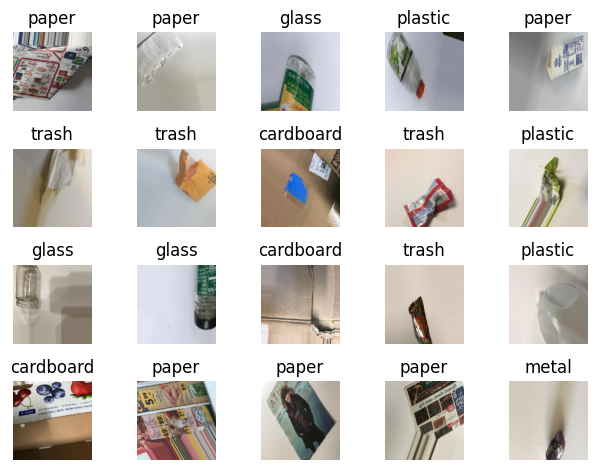

In [13]:
# Obtén un lote de imágenes y etiquetas del generador de entrenamiento
images, labels = next(train_generator)

# Define los nombres de las clases en el mismo orden que se utilizó al crear el generador
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# Muestra las primeras 20 imágenes
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(images[i])
    plt.title(class_names[labels[i].argmax()])
    plt.axis('off')

plt.tight_layout()
plt.show()

## Creación del modelo	

Utilizamos el modelo base de ResNet101V2  y le hacemos un fine-tuning para que se adapte a nuestro problema.

In [14]:
# Create a base model using a pre-trained ResNet101V2 model
base_model = tf.keras.applications.ResNet101V2(
    input_shape=(150, 150, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add new layers on top of the base model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)
# add another layer
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(6, activation='softmax')(x)

# Define the model
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 77, 77, 64)   0           ['conv1_conv[0][0]']         

### Pre-ajuste

In [15]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Pass the callback to the fit method
pre_fine_tuning_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=200,
    callbacks=[early_stop]
)

Epoch 1/200
5/5 [==============================] - 36s 5s/step - loss: 9.8014 - accuracy: 0.1262 - val_loss: 8.3667 - val_accuracy: 0.1667
Epoch 2/200
5/5 [==============================] - 21s 4s/step - loss: 9.0911 - accuracy: 0.1807 - val_loss: 8.1189 - val_accuracy: 0.2111
Epoch 3/200
5/5 [==============================] - 22s 4s/step - loss: 8.7497 - accuracy: 0.2212 - val_loss: 7.9806 - val_accuracy: 0.2222
Epoch 4/200
5/5 [==============================] - 23s 4s/step - loss: 8.4931 - accuracy: 0.2336 - val_loss: 7.8705 - val_accuracy: 0.2500
Epoch 5/200
5/5 [==============================] - 23s 4s/step - loss: 8.4184 - accuracy: 0.2368 - val_loss: 7.7697 - val_accuracy: 0.2944
Epoch 6/200
5/5 [==============================] - 23s 5s/step - loss: 8.2252 - accuracy: 0.2570 - val_loss: 7.6742 - val_accuracy: 0.3333
Epoch 7/200
5/5 [==============================] - 25s 5s/step - loss: 8.2866 - accuracy: 0.2227 - val_loss: 7.5895 - val_accuracy: 0.3444
Epoch 8/200
5/5 [==========

### Fine-tuning

In [17]:
# Unfreeze the last few layers of the base model
for layer in base_model.layers[-20:]:  # Increase the number of layers to fine-tune
    if not isinstance(layer, layers.BatchNormalization):  # Don't apply regularization to BatchNormalization layers
        layer.kernel_regularizer = regularizers.l2(0.01)  # Add L2 regularization
    layer.trainable = True

# Recompile the model (necessary after changing layer trainability)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),  # Experiment with the learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [18]:
# Define the early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Continue training the model with fine-tuning
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=400,
    callbacks=[early_stop]
)


Epoch 1/400
5/5 [==============================] - 37s 6s/step - loss: 4.5877 - accuracy: 0.6044 - val_loss: 4.2181 - val_accuracy: 0.7611
Epoch 2/400
5/5 [==============================] - 25s 5s/step - loss: 4.5955 - accuracy: 0.5919 - val_loss: 4.2158 - val_accuracy: 0.7556
Epoch 3/400
5/5 [==============================] - 26s 5s/step - loss: 4.5743 - accuracy: 0.5997 - val_loss: 4.2133 - val_accuracy: 0.7556
Epoch 4/400
5/5 [==============================] - 26s 5s/step - loss: 4.5911 - accuracy: 0.5857 - val_loss: 4.2117 - val_accuracy: 0.7444
Epoch 5/400
5/5 [==============================] - 26s 6s/step - loss: 4.5512 - accuracy: 0.6153 - val_loss: 4.2101 - val_accuracy: 0.7500
Epoch 6/400
5/5 [==============================] - 26s 5s/step - loss: 4.5425 - accuracy: 0.6184 - val_loss: 4.2083 - val_accuracy: 0.7556
Epoch 7/400
5/5 [==============================] - 26s 5s/step - loss: 4.5247 - accuracy: 0.6371 - val_loss: 4.2065 - val_accuracy: 0.7500
Epoch 8/400
5/5 [==========

## Post-entrenamiento

In [19]:
import pickle
with open('history.pickle', 'wb') as f:
    pickle.dump(history.history, f)
with open('pre_fine_tuning_history.pickle', 'wb') as f:
    pickle.dump(pre_fine_tuning_history.history, f)

In [20]:
model_path = './model/ResNet101V2_TrashClassifierV2.h5'

In [21]:
# Guardamos el resultado del modelo
if not os.path.exists('model'):
    os.makedirs('model')
model.save(model_path)

In [22]:
# Carga el modelo desde el archivo
model = load_model(model_path)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 77, 77, 64)   0           ['conv1_conv[0][0]']         

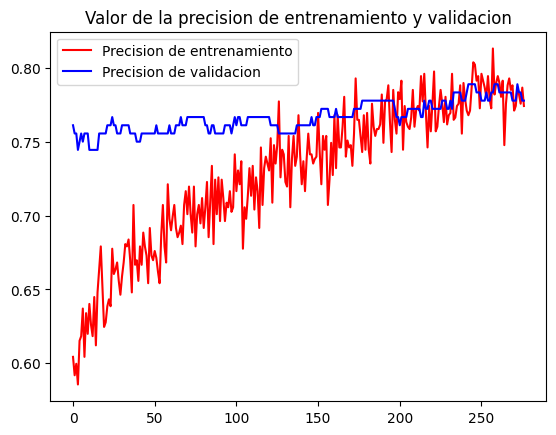

<Figure size 640x480 with 0 Axes>

In [23]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Precision de entrenamiento')
plt.plot(epochs, val_accuracy, 'b', label='Precision de validacion')
plt.title('Valor de la precision de entrenamiento y validacion')
plt.legend(loc=0)
plt.figure()
plt.show()


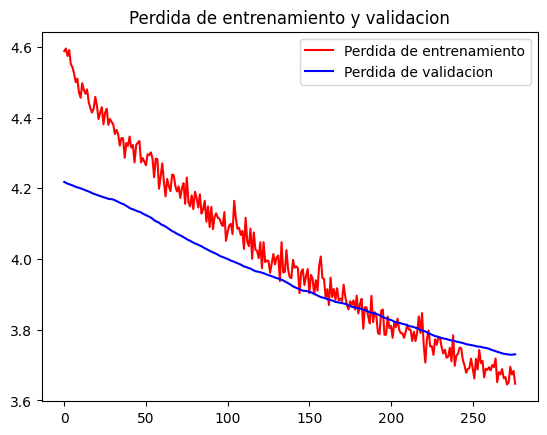

<Figure size 640x480 with 0 Axes>

In [24]:
# plot loss
plt.plot(epochs, loss, 'r', label='Perdida de entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Perdida de validacion')
plt.title('Perdida de entrenamiento y validacion')
plt.legend(loc=0)
plt.figure()
plt.show()

2/2 [==============================] - 7s 502ms/step
Número de errores = 39/180
Precisión =  78.33333333333333 %


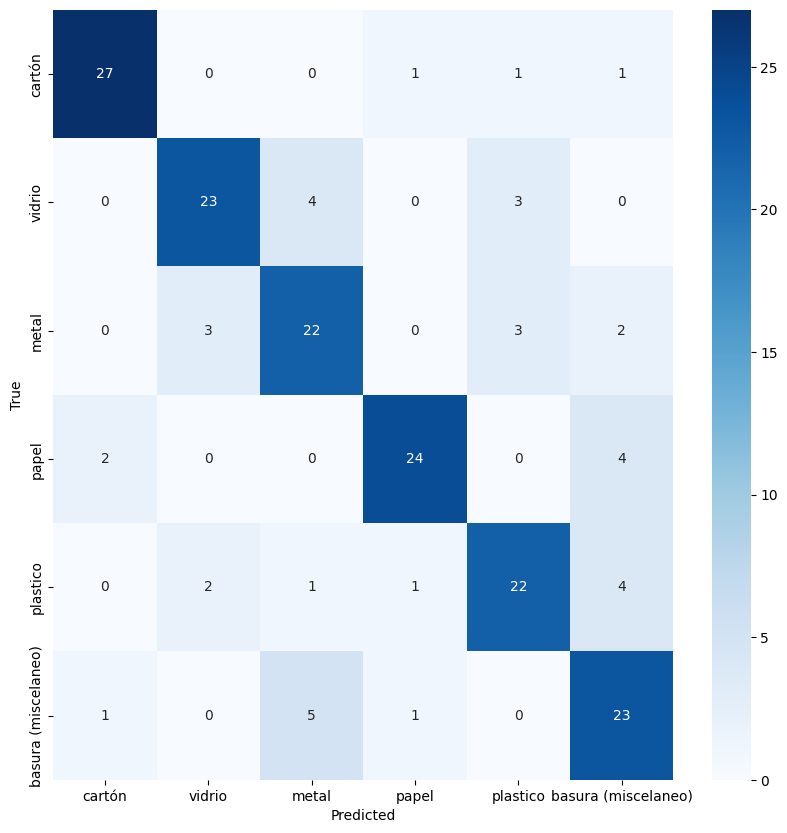

In [25]:
# get the labels of the test images.
test_labels = val_generator.classes

# make a prediction
predictions = model.predict(val_generator)

# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

errors = np.where(predicted_classes != test_labels)[0]
print("Número de errores = {}/{}".format(len(errors),val_generator.samples))
accuracy = (val_generator.samples-len(errors))/val_generator.samples
print("Precisión = ", accuracy*100, "%")

cm = confusion_matrix(test_labels, predicted_classes)
cm_plot_labels = ['cartón','vidrio','metal','papel','plastico','basura (miscelaneo)']

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=cm_plot_labels, yticklabels=cm_plot_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

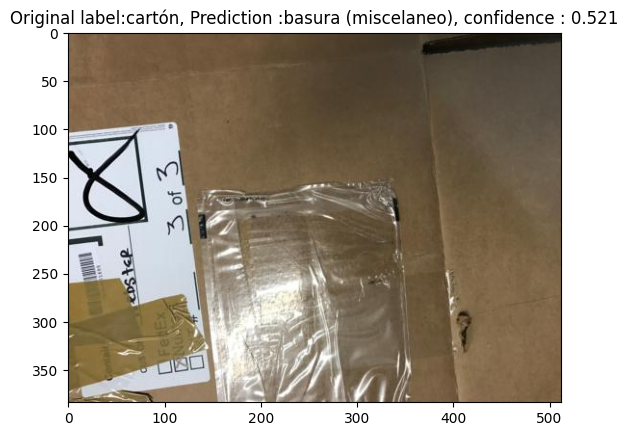

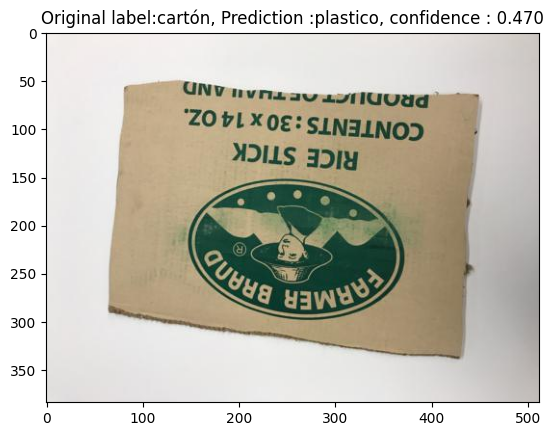

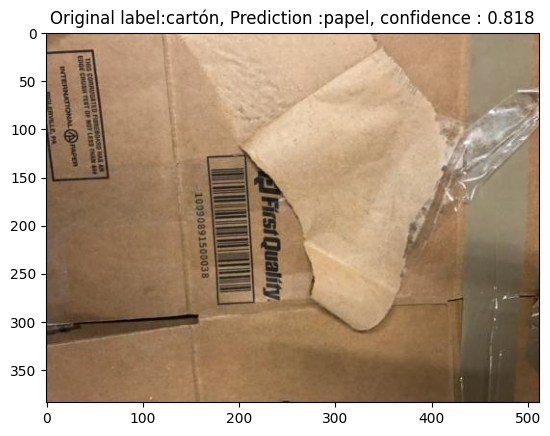

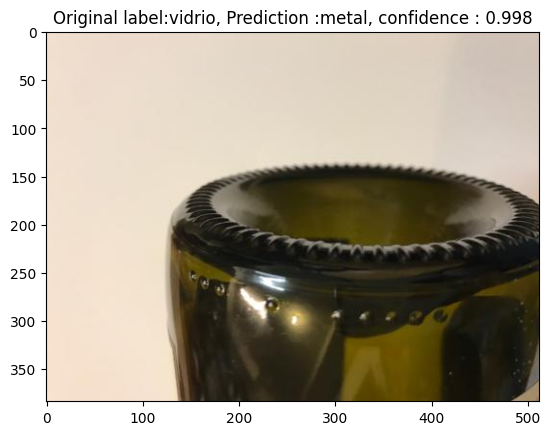

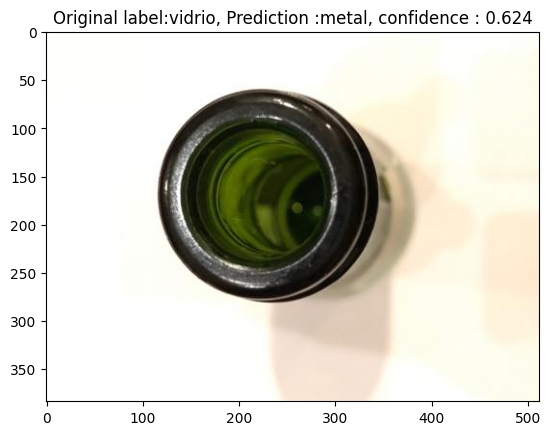

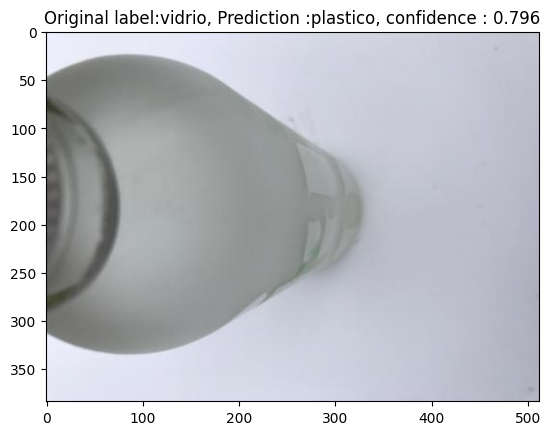

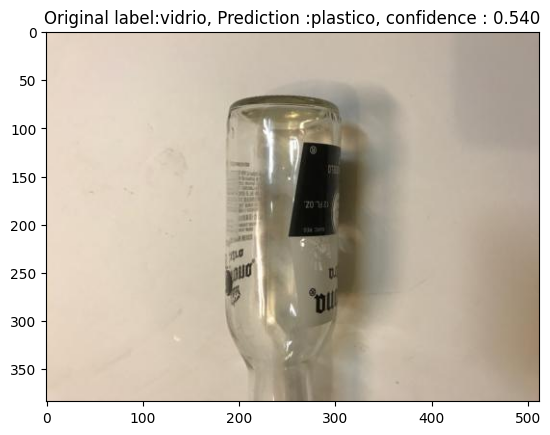

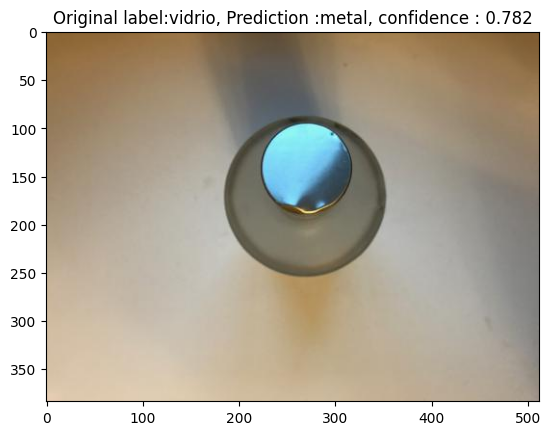

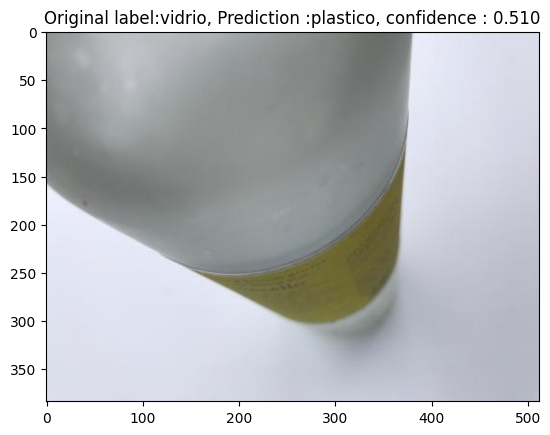

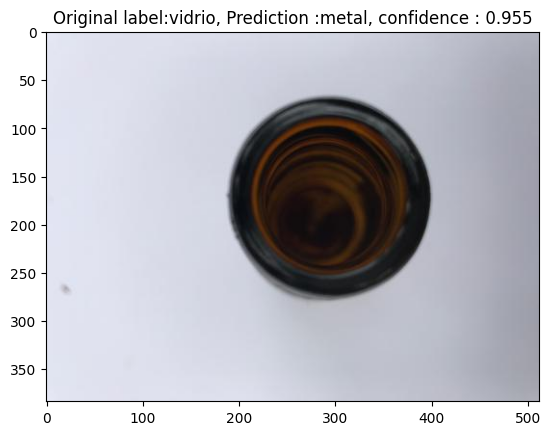

In [26]:
load_img = tf.keras.preprocessing.image.load_img

# show some misclassified examples
for iterator in range(len(errors)):
    ax, fig = plt.subplots(1,1)
    pred_class = np.argmax(predictions[errors[iterator]])
    pred_label = cm_plot_labels[pred_class]

    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        cm_plot_labels[test_labels[errors[iterator]]], pred_label, predictions[errors[iterator]][pred_class])

    original = load_img('{}/{}'.format(validation_path, val_generator.filenames[errors[iterator]]))
    plt.imshow(original)
    plt.title(title)
    plt.show()
    if iterator == 9:
        break

## Pruebas

In [27]:
from src.predict_image import predict_image

# Example usage:
img_path = './data/prueba_2.jpg'  
predicted_class = predict_image(model, img_path)
predicted_class

AttributeError: 'str' object has no attribute 'file'